# Detecting Anomalies in Images
Anomaly detection deals with the problem of finding data items that do not follow the patterns of the majority of data. The task is to distinguish good items from anomalous items. This can be defined as a binary classification problem and as such solved with supervised learning techniques. However, classes can be highly imbalanced.

Imagine an industrial manufacturing processes, where millions of parts are produced every day, but 1 percent of the production may be defective. A supervised learning approach would clearly suffer from this imbalance. Auto-encoders however are perfect for this situation, because they can be trained on normal parts and don't require annotated data. Once trained, we can give it a feature representation for a part and compare autoencoder output with input. The larger the difference, the more likely the input contains an anomaly.

Auto-encoders consist of two parts: an encoder that encodes the input data using a reduced representation and a decoder that attempts to reconstruct the original input data from the reduced representation. The network is subject to constraints that force the auto-encoder to learn a compressed representation of the training set. It does this in an unsupervised manner and is therefore most suitable for problems related to anomaly detection.

This notebook gives an example for an auto-encoder trained on [UCSD Anomaly Detection Dataset](http://www.svcl.ucsd.edu/projects/anomaly/dataset.htm)

*Let's start by importing necessary Libraries, downloading and extracting the dataset:*


In [1]:
import os
import numpy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

### Extracting the dataset

In [2]:
#!tar -xzvf "/content/drive/MyDrive/Anomaly Detection/UCSD_Anomaly_Dataset.tar.gz"

## Convolutional Auto Encoders

Let's define the network structure. The encoder consists of two convolutional and two MaxPooling layers. Encoder and Decoder are connected by a fully connected layer. The larger this bottleneck, the more information can be reconstructed. The decoder consists of two Upsampling layers and two Deconvolutions.

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" alt="Autoencoder" width="500"/>

### Creating the UCSD Anomaly Detection Dataset and DataLoader

In this section, we define a custom dataset class for the UCSD Anomaly Detection Dataset. We then specify the dataset path and transformations, and create a DataLoader to handle batching and shuffling of the data for efficient training.
Images from the folder UCSDped1 have the format 158x238 pixels. They are rescaled to 100x100 and normalized.




In [8]:
import glob
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class UCSDAnomalyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = sorted(glob.glob(self.root_dir + '/*/*'))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        image = Image.open(filename)
        if self.transform:
            image = self.transform(image)
        return image

# Define the path to the dataset
dataset_path = 'D:\\UCSD\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1\\Train'

# Define the transformation to resize images to 100x100 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Create an instance of the UCSDAnomalyDataset
ucsd_dataset = UCSDAnomalyDataset(root_dir=dataset_path, transform=transform)

# Define batch size
batch_size = 32

# Create DataLoader
dataloader = DataLoader(ucsd_dataset, batch_size=batch_size, shuffle=True)

print("Dataset Loaded Successfully!!")


Dataset Loaded Successfully!!


### Defining the Convolutional Autoencoder Model

In this section, we define a convolutional autoencoder model using PyTorch. Autoencoders are a type of neural network used to learn efficient codings of input data in an unsupervised manner. The model consists of encoder and decoder layers for learning a compact representation of input images and then reconstructing them.
Architecture of the Autoencoder

The autoencoder consists of two main parts: the encoder and the decoder.

   #### Encoder: The encoder compresses the input image into a lower-dimensional representation. It includes:
        Convolutional layers to extract features from the image.
        Max pooling layers to reduce the spatial dimensions of the feature maps.

  #### Decoder: The decoder reconstructs the image from the lower-dimensional representation. It includes:
        Fully connected layers to expand the compressed representation back to the original image dimensions.
        Transposed convolutional layers to increase the spatial dimensions and reconstruct the original image.

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        # Encoder Layers
        self.encoder_conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)  # Changed kernel size to (5, 5) and output channels to 32
        self.encoder_pool1 = nn.MaxPool2d(2, 2)
        self.encoder_conv2 = nn.Conv2d(32, 16, 3, stride=1, padding=1)  # Adjusted input channels to 32
        self.encoder_pool2 = nn.MaxPool2d(2, 2)
        # Bottleneck Layer
        self.bottleneck = nn.Linear(16*25*25, 4500)  # Adjusted input size based on the changes in encoder layers
        # Decoder Layers
        self.decoder_linear = nn.Linear(4500, 16*25*25)
        self.decoder_conv1 = nn.ConvTranspose2d(16, 32, 3, stride=2, padding=1, output_padding=1)  # Adjusted input and output channels
        self.decoder_conv2 = nn.ConvTranspose2d(32, 1, 5, stride=2, padding=2, output_padding=1)  # Changed kernel size to (5, 5) and adjusted input and output channels

    def forward(self, x):
        # Encoder
        x = F.relu(self.encoder_conv1(x))
        x = self.encoder_pool1(x)
        x = F.relu(self.encoder_conv2(x))
        x = self.encoder_pool2(x)

        # Flatten for fully connected layer
        x = x.view(-1, 16*25*25)
        # Bottleneck Layer
        x = F.relu(self.bottleneck(x))
        # Decoder
        x = F.relu(self.decoder_linear(x))
        x = x.view(-1, 16, 25, 25)  # Adjusted input channels for decoder ConvTranspose2d
        x = F.relu(self.decoder_conv1(x))
        x = torch.sigmoid(self.decoder_conv2(x))  # Using sigmoid activation for reconstruction
        return x

# Create an instance of the ConvAutoEncoder model
model = ConvAutoEncoder()
print(model)


ConvAutoEncoder(
  (encoder_conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (encoder_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Linear(in_features=10000, out_features=4500, bias=True)
  (decoder_linear): Linear(in_features=4500, out_features=10000, bias=True)
  (decoder_conv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoder_conv2): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)


### Training the Convolutional Autoencoder

This section demonstrates the training process for the convolutional autoencoder model using the UCSD Anomaly Detection Dataset. We define the model, loss function, optimizer, and learning rate scheduler, then move the model to the appropriate device (CPU or GPU). The training loop iterates over the dataset for a specified number of epochs, updating the model parameters to minimize the reconstruction loss.
This encompasses the entire training process, including model initialization, loss calculation, optimizer setup, device configuration, and the training loop. During training, the model parameters are updated iteratively to minimize the reconstruction loss, resulting in a trained autoencoder model capable of efficiently encoding and decoding images.



In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your autoencoder model (ConvAutoEncoder)
model = ConvAutoEncoder()


# Define loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam) with learning rate decay
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, inputs in enumerate(dataloader):
        inputs = inputs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(ucsd_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Step the scheduler
    scheduler.step()

print("Training complete!")


Epoch [1/15], Loss: 0.0062
Epoch [2/15], Loss: 0.0033
Epoch [3/15], Loss: 0.0026
Epoch [4/15], Loss: 0.0022
Epoch [5/15], Loss: 0.0020
Epoch [6/15], Loss: 0.0018
Epoch [7/15], Loss: 0.0017
Epoch [8/15], Loss: 0.0015
Epoch [9/15], Loss: 0.0015
Epoch [10/15], Loss: 0.0014
Epoch [11/15], Loss: 0.0013
Epoch [12/15], Loss: 0.0013
Epoch [13/15], Loss: 0.0013
Epoch [14/15], Loss: 0.0013
Epoch [15/15], Loss: 0.0013
Training complete!


### Saving and Loading Model Parameters

This section demonstrates how to save and load the parameters of the convolutional autoencoder model using PyTorch.

In [61]:
# Save model parameters
#torch.save(model.state_dict(), 'new_autoencoder_model123.pth')
# Load Model Parameters
model = ConvAutoEncoder()


model.load_state_dict(torch.load('new_autoencoder_model1.pth'))

model.eval()

ConvAutoEncoder(
  (encoder_conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (encoder_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Linear(in_features=10000, out_features=4500, bias=True)
  (decoder_linear): Linear(in_features=4500, out_features=10000, bias=True)
  (decoder_conv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoder_conv2): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)

### Creating the UCSD Anomaly Test Dataset and DataLoader

This section outlines the process of setting up a test dataset and data loader to evaluate the performance of the convolutional autoencoder model on unseen data from the UCSD Anomaly Detection Dataset


In [62]:
import glob
from PIL import Image
import torch 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class UCSDAnomalyTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = sorted(glob.glob(self.root_dir + '/*'))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        image = Image.open(filename)
        if self.transform:
            image = self.transform(image)
        return image

# Define the path to the test dataset
test_dataset_path = 'D:\\UCSD\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1\\Test\\Test024'

# Define the transformation for the test dataset
test_transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to 100x100
    transforms.ToTensor()            # Convert images to tensors
])

# Create an instance of the UCSDAnomalyTestDataset with the transformation
test_dataset = UCSDAnomalyTestDataset(root_dir=test_dataset_path, transform=test_transform)

# Define batch size for the test DataLoader
test_batch_size = 1  # You can adjust this as needed

# Create DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print("Test DataLoader created successfully!")


Test DataLoader created successfully!


Just Checking the output of the image of one of the images From test dataset.

Shape of the first image: torch.Size([1, 100, 100])


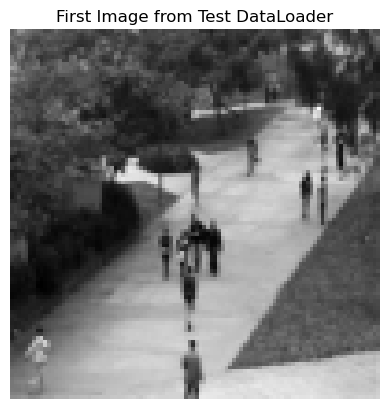

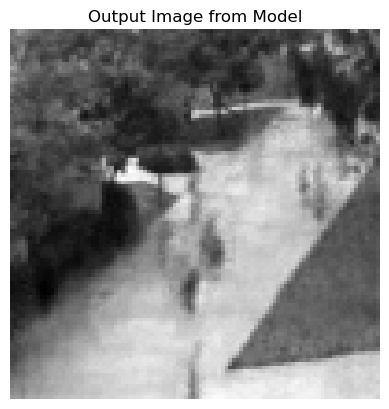

In [63]:
# Get the first batch from the test DataLoader
first_batch = next(iter(test_dataloader))

# Access the first image within the batch
first_image = first_batch[0]

# Print the shape of the first image
print("Shape of the first image:", first_image.shape)

# Optionally, you can convert the tensor to a numpy array for visualization
first_image_numpy = first_image.squeeze().cpu().numpy()

plt.imshow(first_image_numpy, cmap='gray')
plt.title('First Image from Test DataLoader')
plt.axis('off')  # Turn off axis
plt.show()

# Forward pass to obtain the output image from the model
output_image = model(first_image.unsqueeze(0).to(device))  # Forward pass with the first image

# Convert the output tensor to a numpy array and squeeze it to remove any singleton dimensions
output_image_numpy = output_image.squeeze().cpu().detach().numpy()

# Plot the output image
plt.imshow(output_image_numpy, cmap='gray')
plt.title('Output Image from Model')
plt.axis('off')  # Turn off axis
plt.show()
# Now, you can visualize or process the first image as needed


A helper function that will plot input and output images and the differnce between them.

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def plot(img, output, diff, H, threshold, counter):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()

    ax0.set_title('Input image')
    ax1.set_title('Reconstructed image')
    ax2.set_title('Difference')
    ax3.set_title('Anomalies')

    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')

    x, y = np.where(H > threshold)
    ax3.scatter(y, x, edgecolor='red',facecolors = 'none',  s=200, marker = 's')

    plt.axis('off')

    fig.savefig(f'C:\\Users\\Lenovo\Desktop\\Machine learning\\Anomaly Detectoin\\img\\{counter}.png')
    plt.close(fig)


This goes iteratively to every image present in test024 folder and plots the data and save it in specified folder

In [68]:
import torch
import torch.nn.functional as F
import numpy as np

# Define the threshold for anomaly detection
threshold = 6 * 255  # Adjust as needed

# Define the convolution kernel
kernel_size = 4  # Size of the kernel for convolution
kernel = torch.ones(1, 1, kernel_size, kernel_size).to(device)  # Define a kernel of ones
counter = 0;
# Iterate over the images in the test DataLoader
for batch_idx, inputs in enumerate(test_dataloader):
    # Transfer the input images to the device (GPU if available)
    inputs = inputs.to(device)

    # Forward pass to obtain the output images from the model
    outputs = model(inputs)

    # Convert tensors to numpy arrays for visualization
    input_images = inputs.cpu().numpy() * 255.0  # Convert to numpy and scale to [0, 255]
    output_images = outputs.cpu().detach().numpy() * 255.0  # Convert to numpy and scale to [0, 255]

    # Compute the absolute differences between input and output images
    differences = np.abs(output_images - input_images)

    # Perform convolution on the differences using the defined kernel
    H = F.conv2d(torch.tensor(differences).to(device), kernel, padding=kernel_size // 2)[0, 0].cpu().numpy()

    # Detect anomalies based on the processed differences (H) and the threshold
    anomalies = H > threshold

    # Now, you can use the plot function to visualize the input images, output images, differences,
    # and anomalies for each image in the batch
    for i in range(len(input_images)):
        plot(input_images[i, 0], output_images[i, 0], differences[i, 0], H, threshold, counter)
        counter+=1


Now For Better Visualisaton, Taking all the images and making a Animation out of it.

Video created successfully!


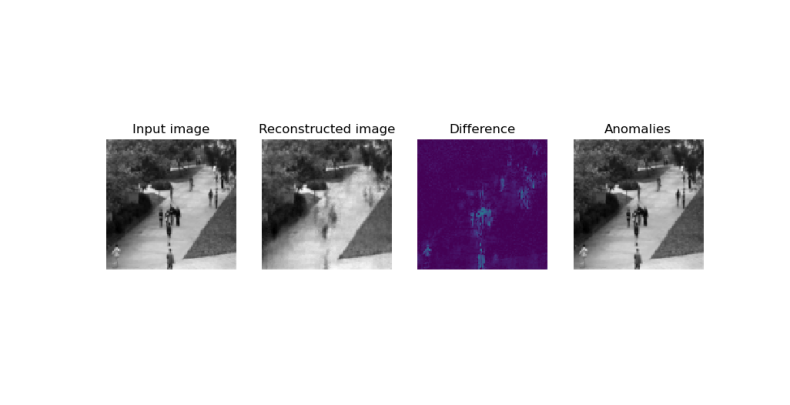

In [69]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Folder containing the PNG images
folder_path = "C:\\Users\\Lenovo\Desktop\\Machine learning\\Anomaly Detectoin\\img"

# Output video file path
output_path = "output1.mp4"

# List all the PNG files in the folder
file_names = [f"{folder_path}/{i}.png" for i in range(200)]

# Function to update the plot for each frame of the animation
def update(frame):
    img = plt.imread(file_names[frame])
    im.set_array(img)
    return [im]

# Load the first image to get its size
img = plt.imread(file_names[0])
height, width, _ = img.shape

# Create a figure with the size of the first image
fig = plt.figure(figsize=(width/100, height/100))
ax = plt.axes()
ax.axis('off')

# Display the first image
im = ax.imshow(img)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(file_names), interval=50)

# Save the animation as a video
ani.save(output_path, writer='ffmpeg', fps=30)  # Adjust fps as needed

print("Video created successfully!")


### Conclusion:

In this notebook, we successfully implemented an anomaly detection system using a Convolutional Autoencoder (CAE) on the UCSD dataset. The UCSD dataset contains video sequences captured from different scenes, both normal and abnormal activities, making it suitable for anomaly detection tasks.

We began by preparing the dataset, creating a custom Dataset class to load and preprocess the images. Then, we designed a Convolutional Autoencoder architecture comprising encoder and decoder layers. The encoder extracts meaningful features from the input images, while the decoder reconstructs the images from the encoded representations.

During the training phase, we utilized Mean Squared Error (MSE) loss to measure the difference between the input and output images. We employed the Adam optimizer with a learning rate scheduler to train the model efficiently.

After training the CAE, we evaluated its performance on the test dataset. We visualized the reconstruction of input images and computed the differences between the input and output images. Anomalies were detected by comparing the differences against a predefined threshold.

Finally, we generated a video summarizing the anomaly detection process, showcasing input images, reconstructed images, differences, and detected anomalies.

In conclusion, this notebook demonstrates the effectiveness of Convolutional Autoencoders for anomaly detection tasks, particularly on the UCSD dataset. Future work could involve fine-tuning the model architecture and exploring advanced anomaly detection techniques to improve detection accuracy further.